In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [136]:
import sys
sys.path.append('/content/drive/MyDrive/dl/src')  # Replace 'YourProjectFolder' with the actual folder name

In [137]:
#@title Setup & Imports
import os
import zipfile
import pandas as pd
# from src.MAE.MAE_datas1et import MAEDataset
# from src.MAE.MAE_model import MaskedAutoencoderCNN
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



from PIL import Image
import json
# import nltk
# from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import io
import random
import src.config
import src.dataset
import src.utils
import src.eval
import src.model
from src.config import *
from src.dataset import load_csv_paths, create_dataloaders
from src.utils import build_vocab
from src.model import GRNN
from src.train import train_model, plot_history
from src.eval import test_loss, generate_question
from src.dataset import VQGTensorDataset
from src.model import TransformerModel
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 4
LR = 0.001
EPOCHS = 7
MAX_LENGTH = 20
BATCH_SIZE = 256

In [139]:
import nltk
import os

nltk.download('punkt', download_dir='~/nltk_data')
nltk.data.path.append(os.path.expanduser('~/nltk_data'))


[nltk_data] Downloading package punkt to ~/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [140]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jacobfernandez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [129]:
import pandas as pd

def expand_questions(csv_path):
    df = pd.read_csv(csv_path)
    expanded_rows = []
    for _, row in df.iterrows():
        questions = str(row["questions"]).split('---')
        for q in questions:
            q = q.strip()
            if q:
                expanded_rows.append({
                    "image_id": row["image_id"],
                    "tensor_path": row["tensor_path"],
                    "questions": q  # single question per row
                })
    return pd.DataFrame(expanded_rows)


In [163]:
gqa_test_tidx = pd.read_csv("data/gqa_test_tensor_index.csv")
gqa_train_tidx   = pd.read_csv("data/gqa_train_tensor_index.csv")
gqa_val_tidx  = pd.read_csv("data/gqa_val_tensor_index.csv")

In [164]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import nltk

class VQGTensorDataset(Dataset):
    def __init__(self, csv_path, vocab, max_length=20, tensor_dir="data/gqa_resnet_data"):
        self.df = pd.read_csv(csv_path)
        self.vocab = vocab
        self.max_length = max_length
        self.tensor_dir = tensor_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tensor_path = os.path.join(self.tensor_dir, row['tensor_path'].strip())
        
        if not os.path.exists(tensor_path):
            raise FileNotFoundError(f"Tensor not found at {tensor_path}")

        tensor = torch.load(tensor_path).float()
        question = str(row["questions"]).strip().lower()
        tokens = nltk.word_tokenize(question)
        indexed_tokens = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
        padded_tokens = indexed_tokens[:self.max_length] + [self.vocab["<pad>"]] * max(0, self.max_length - len(indexed_tokens))

        return tensor, torch.tensor(padded_tokens), question




In [165]:
train_df = gqa_train_tidx
val_df   = gqa_val_tidx
test_df  = gqa_test_tidx

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Concatenate Datasets
combined_df = pd.concat([train_df, val_df, test_df])

# 2. Sample Unique Images (based on 'tensor_path')
unique_image_ids = combined_df['tensor_path'].unique()  # Get unique image IDs
subset_image_ids = np.random.choice(unique_image_ids, size=10000, replace=False)  # Sample 10k unique IDs
subset_df = combined_df[combined_df['tensor_path'].isin(subset_image_ids)]  # Filter DataFrame

# 3. Train-Validation-Test Split
train_df, temp_df = train_test_split(subset_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 4. Save as CSV files
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

In [166]:
questions = pd.concat([train_df, val_df, test_df])["questions"].dropna().tolist()
vocab, idx_to_word = build_vocab(questions)

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBED_SIZE = 256         # Token embedding size
HIDDEN_SIZE = 512        # Hidden size for Transformer decoder
NUM_LAYERS = 4           # Fewer layers for smaller dataset

# === Optimization ===
LR = .001               # Lower learning rate for stability
WEIGHT_DECAY = 1e-5      # Regularization
DROPOUT = 0.2            # Add if you're using dropout in the model
EPOCHS = 10              # Slightly longer for smaller dataset
GRAD_CLIP = 1.0          # Prevent exploding gradients

# === Data ===
MAX_LENGTH = 20          # Max token length per question
BATCH_SIZE = 128  

In [168]:
train_dataset = VQGTensorDataset('train_split.csv', vocab, MAX_LENGTH)
val_dataset   = VQGTensorDataset('val_split.csv', vocab, MAX_LENGTH)
test_dataset  = VQGTensorDataset('test_split.csv', vocab, MAX_LENGTH)

# Dataloaders
from torch.utils.data import DataLoader
dataloaders = {
    "gqa": {
        "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
        "val":   DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers =0),
        "test":  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers =0),
    }
}

In [172]:
# -*- coding: utf-8 -*-
"""train.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/15lyXSu06z14MKsLJS0LZmEVRnh7U5Hrz
"""

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.models as models
import clip  # Add this import at the top of your file


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.gru(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)
        out, _ = self.lstm(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=8, num_layers=6, max_len=50):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Embedding(vocab_size, embed_size),
            nn.BatchNorm1d(embed_size)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear = nn.Sequential(
            nn.Linear(embed_size, vocab_size),
            nn.BatchNorm1d(vocab_size)
        )

        self.pos_embed = nn.Parameter(torch.zeros(1, max_len + 1, embed_size))  # +1 for the image feature
        nn.init.normal_(self.pos_embed, std=0.02)  # Optional: initialize

    def forward(self, features, captions):
        emb = self.embed[0](captions)
        B, T, E = emb.shape
        emb = self.embed[1](emb.view(-1, E)).view(B, T, E)

        # Prepend image feature
        inputs = torch.cat((features.unsqueeze(1), emb[:, :-1, :]), dim=1)

        # Apply positional embeddings safely
        pos_emb = self.pos_embed[:, :inputs.size(1), :]
        inputs = inputs + pos_emb

        out = self.transformer(inputs)
        logits = self.linear[0](out)
        logits = self.linear[1](logits.view(-1, logits.size(-1))).view(*logits.shape)
        return logits


class GRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)

class LSTMModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        # resnet.load_state_dict(torch.load("pretrained_encoder.pth"))
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.project = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.BatchNorm1d(embed_size),
            nn.ReLU()
        )
        self.decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

    def forward(self, images, captions):
        feats = self.encoder(images).view(images.size(0), -1)
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)


class ClipTransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=4, use_clip=True):
        super().__init__()
        self.use_clip = use_clip

        self.img_fc = nn.Linear(512, embed_size)  # CLIP ViT-B/16 has 512-dim output

        if self.use_clip:
            # Load CLIP's ViT-B/16 encoder
            self.clip_model, _ = clip.load("ViT-B/16", device="cpu")  # Move to GPU in forward
            for param in self.clip_model.visual.parameters():
                param.requires_grad = False
        else:
            # Fallback if using direct 2048-dim features
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )

        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images_or_feats, captions):
        if self.use_clip:
            image_features = self.clip_model.encode_image(images_or_feats).float()  # CLIP expects normalized image tensors
        else:
            image_features = images_or_feats  # 2048-dim precomputed .pt

        projected_feats = self.img_fc(image_features)
        return self.decoder(projected_feats, captions)




# class TransformerModel(nn.Module):
#     def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=2):
#         super().__init__()
#         resnet = models.resnet50(pretrained=True)
#         self.encoder = nn.Sequential(*list(resnet.children())[:-1])
#         for param in self.encoder.parameters():
#             param.requires_grad = False
#         self.project = nn.Sequential(
#             nn.Linear(2048, embed_size),
#             nn.BatchNorm1d(embed_size),
#             nn.ReLU()
#         )
#         self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

#     def forward(self, images, captions):
#         feats = self.encoder(images).view(images.size(0), -1)
#         projected_feats = self.project(feats)
#         return self.decoder(projected_feats, captions)

class TransformerModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=4, num_layers=4, use_resnet=True):
        super().__init__()
        self.use_resnet = use_resnet

        self.img_fc = nn.Linear(2048, embed_size)
        


        if self.use_resnet:
            resnet = models.resnet50(pretrained=True)
            self.encoder = nn.Sequential(*list(resnet.children())[:-1])
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )
        else:
            # Directly project the 2048-dim precomputed tensor
            self.project = nn.Sequential(
                nn.Linear(2048, embed_size),
                nn.BatchNorm1d(embed_size),
                nn.ReLU()
            )

        self.decoder = DecoderTransformer(embed_size, vocab_size, num_heads, num_layers)

    def forward(self, images_or_feats, captions):
        if self.use_resnet:
            feats = self.encoder(images_or_feats).view(images_or_feats.size(0), -1)
        else:
            feats = images_or_feats  # already 2048-dim features
        projected_feats = self.project(feats)
        return self.decoder(projected_feats, captions)



def train_model(model, train_loader, val_loader, vocab, criterion, optimizer, device, epochs):
    history = {"train_loss": [], "val_loss": []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, caps, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"): #Modified line

            imgs, caps = imgs.to(device), caps.to(device)

            out = model(imgs, caps)
            loss = criterion(out.view(-1, len(vocab)), caps.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, caps, _ in val_loader:
                imgs, caps = imgs.to(device), caps.to(device)
                out = model(imgs, caps)
                loss = criterion(out.view(-1, len(vocab)), caps.view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        # Print summary after each epoch
        print(f"Epoch {epoch+1} Summary: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return history


def plot_history(history):
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training History")
    plt.show()

In [175]:
def train_model(model, train_loader, val_loader, vocab, criterion, optimizer, device, epochs,
                patience=3, checkpoint_path="best_model.pth"):
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, caps, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, caps = imgs.to(device), caps.to(device)
            out = model(imgs, caps)
            loss = criterion(out.view(-1, len(vocab)), caps.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # === Validation ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, caps, _ in val_loader:
                imgs, caps = imgs.to(device), caps.to(device)
                out = model(imgs, caps)
                loss = criterion(out.view(-1, len(vocab)), caps.view(-1))
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1} Summary: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # === Early Stopping Check ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Model improved. Saved to {checkpoint_path}")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= patience:
            print(f"⏹️ Early stopping triggered after {epoch+1} epochs")
            break

    return history


In [176]:
# from model import TransformerModel  # assuming you've imported from your updated model.py

transformer_model = TransformerModel(EMBED_SIZE, len(vocab), use_resnet = False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=LR, weight_decay=1e-5)


In [178]:
history_transformer = train_model(transformer_model, dataloaders["gqa"]["train"], dataloaders["gqa"]["val"], vocab, criterion, optimizer, device, 50)
plot_history(history_transformer)
test_loss(transformer_model, dataloaders["gqa"]["test"], vocab, criterion, device)

Epoch 1: 100%|██████████| 12715/12715 [1:16:33<00:00,  2.77it/s]


Epoch 1 Summary: Train Loss = 0.2343, Val Loss = 0.0037
✅ Model improved. Saved to best_model.pth


Epoch 2: 100%|██████████| 12715/12715 [1:18:12<00:00,  2.71it/s]


Epoch 2 Summary: Train Loss = 0.0036, Val Loss = 0.0019
✅ Model improved. Saved to best_model.pth


Epoch 3:  50%|█████     | 6379/12715 [39:11<38:55,  2.71it/s]  


KeyboardInterrupt: 

In [ ]:
# Assuming your trained Transformer model is named 'transformer_model'
torch.save(transformer_model.state_dict(), 'transformer_model.pth')

In [179]:
# Create a new instance of your model
loaded_model = TransformerModel(EMBED_SIZE, len(vocab), use_resnet=False).to(device)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()

TransformerModel(
  (img_fc): Linear(in_features=2048, out_features=256, bias=True)
  (project): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (decoder): DecoderTransformer(
    (embed): Sequential(
      (0): Embedding(2891, 256)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_a

In [180]:
from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Load ResNet feature extractor once
def load_resnet(resnet_weights_path, device):
    resnet = models.resnet50()
    resnet.load_state_dict(torch.load(resnet_weights_path, map_location=device))
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove classifier
    resnet.eval().to(device)
    return resnet

# Inference function
def generate_question(model, image_path, vocab, idx_to_word, device, resnet_weights_path=None):
    model.eval()

    # === Step 1: Load raw image ===
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]

    # === Step 2: Get feature vector ===
    if model.use_resnet:
        feat = model.encoder(img_tensor).view(1, -1)  # [1, 2048]
    else:
        if resnet_weights_path is None:
            raise ValueError("resnet_weights_path must be provided when use_resnet=False.")

        resnet = load_resnet(resnet_weights_path, device)
        with torch.no_grad():
            feat = resnet(img_tensor).view(1, -1)  # [1, 2048]

    feat = model.project(feat)

    # === Step 3: Generate sequence ===
    inp = torch.tensor([[vocab["<start>"]]], device=device)
    output = []

    for _ in range(20):
        out = model.decoder(feat, inp)
        pred = out[0, -1].argmax().item()
        if pred == vocab["<end>"]:
            break
        output.append(pred)
        inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)

    # === Step 4: Decode and visualize ===
    decoded = " ".join(idx_to_word.get(i, "<unk>") for i in output)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated: {decoded}")
    plt.show()

    return decoded


In [181]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os

def generate_question(model, test_loader, vocab, idx_to_word, device, image_dir="data/gqa/images"):
    model.eval()
    model.to(device)

    # === Step 1: Get a sample from the dataloader
    image_tensor, _, original_question = next(iter(test_loader))
    image_tensor = image_tensor[0].unsqueeze(0).to(device)  # [1, 2048]
    original_question = original_question[0]

    # === Step 2: Get the image path from the tensor file name (if available)
    sample_path = test_loader.dataset.df.iloc[0]['tensor_path']
    image_id = sample_path.split("_")[-1].replace(".pt", "")  # e.g., '2349170'
    image_path = os.path.join(image_dir, f"{image_id}.jpg")

    # === Step 3: Try to load and display the image
    try:
        image = Image.open(image_path).convert("RGB")
        plt.imshow(image)
        plt.axis("off")
    except Exception as e:
        print(f"⚠️ Could not load image: {image_path}\nError: {e}")
        image = None

    # === Step 4: Generate caption from image_tensor
    inp = torch.tensor([[vocab["<start>"]]], device=device)
    output = []

    with torch.no_grad():
        feat = model.project(image_tensor)
        for _ in range(20):
            out = model.decoder(feat, inp)
            pred = out[0, -1].argmax().item()
            if pred == vocab["<end>"]:
                break
            output.append(pred)
            inp = torch.cat([inp, torch.tensor([[pred]], device=device)], dim=1)

    decoded = " ".join(idx_to_word.get(i, "<unk>") for i in output)
    print(f"\n🧠 Generated: {decoded}")
    print(f"📘 Original: {original_question}")

    if image:
        plt.title(f"Generated: {decoded}\nOriginal: {original_question}")
        plt.show()



🧠 Generated: are moustache are motorcycles are motorcycles are motorcycles are motorcycles moustache motorcycles motorcycles motorcycles motorcycles motorcycles motorcycles motorcycles motorcycles motorcycles
📘 Original: are there lions under the clock?


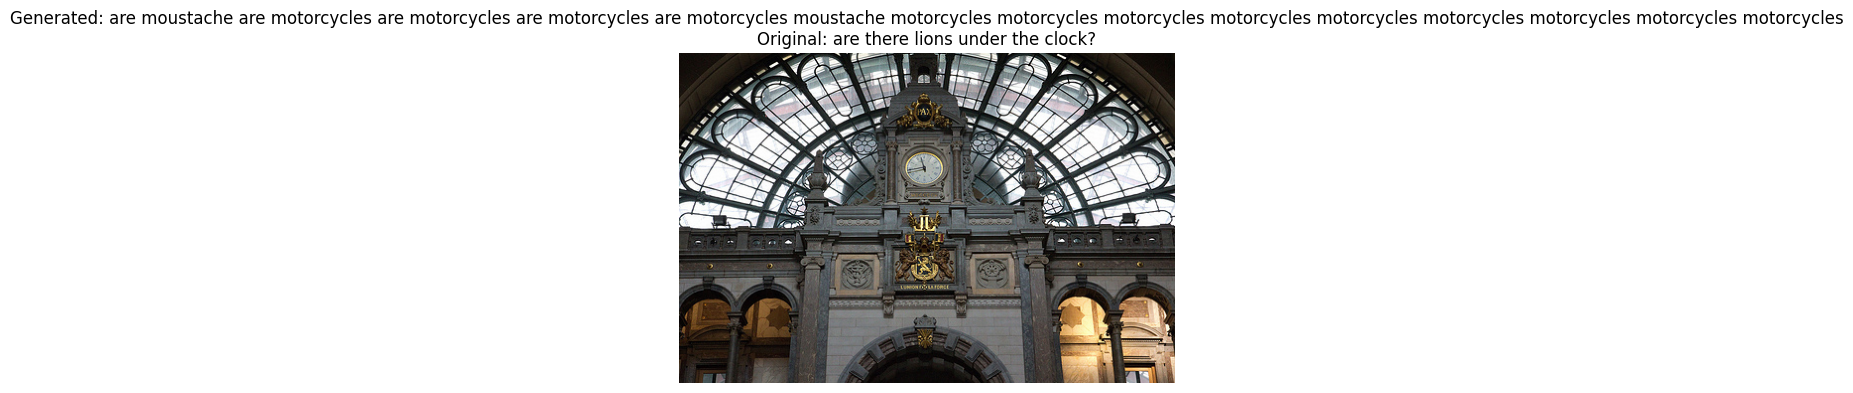

In [182]:
generate_question(
    model=transformer_model,
    # image_path="data/gqa/images/630.jpg",
    test_loader=dataloaders["gqa"]["test"],
    vocab=vocab,
    idx_to_word=idx_to_word,
    device=device
    # ,
    # resnet_weights_path="resnet50-0676ba61.pth"
)


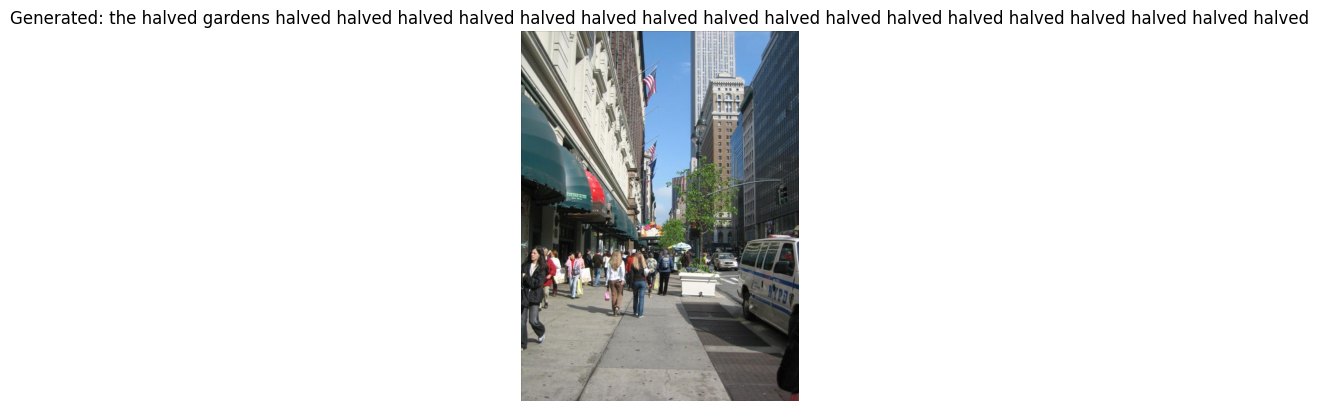

'the halved gardens halved halved halved halved halved halved halved halved halved halved halved halved halved halved halved halved halved'

In [ ]:
generate_question(
    model=transformer_model,
    image_path="data/gqa/images/630.jpg",
    vocab=vocab,
    idx_to_word=idx_to_word,
    device=device
    # ,
    # resnet_weights_path="resnet50-0676ba61.pth"
)
